# Problem 1 - Perceptron

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

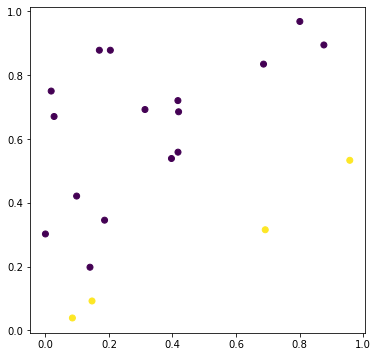

In [401]:
np.random.seed(1)

data = np.c_[np.random.uniform(0, 1, size=(20,2)), np.zeros(20)] 
test = np.c_[np.random.uniform(0, 1, size=(1000,2)), np.zeros(1000)] 


for i in range(len(data)):
    if data[i,0] - data[i,1] > 0:
        data[i,2] = 1
    else:
        data[i,2] = -1
        
for i in range(len(test)):
    if test[i,0] - test[i,1] > 0:
        test[i,2] = 1
    else:
        test[i,2] = -1
 
X,Y = data[:,0:2],data[:,2:]
X_test,Y_test = test[:,0:2],test[:,2:]


x_1 = data[:,0]  
x_2 = data[:,1]  
label =  data[:,2]  


#randomly generated inside the unit square in the first quadrant
fig = plt.figure(figsize=(6,6))
plt.scatter(x_1, x_2, c=label)

In [406]:
class Perceptron:

    def __init__(self, learning_rate=1, n_iters=50, a = 1):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.a = a
        
    def train(self, X, y):
        
        self.weights = np.zeros(2)
        
        if self.a == 1:
                for i in range(self.n_iters):
                    for ind, x_i in enumerate(X):
                        if np.dot(X[ind], self.weights)*y[ind] <= 0:
                            self.weights += self.lr*X[ind]*y[ind]
        else:
                for i in range(self.n_iters):
                    for ind, x_i in enumerate(X):
                        if (np.dot(X[ind], self.weights)*y[ind]) < 1:
                            self.weights += self.lr*X[ind]*y[ind] # no regurization is used here
        return self.weights
                        
    def predict(self, X,y):
        
        y_hat = np.zeros(1000)
        for ind, x_i in enumerate(X):
            y_hat[ind]=np.sign(np.dot(X[ind], self.weights))
        return accuracy_score(y, y_hat) 
    
    
Standard= Perceptron(learning_rate=1, n_iters=100, a = 1)
w_standard=Standard.train(X,Y)
y_standard = Standard.predict(X_test,Y_test)

Hinge= Perceptron(learning_rate=1, n_iters=100, a = None)
w_hinge=Hinge.train(X,Y)
y_Hinge=Hinge.predict(X_test,Y_test)

print("The trained weights for standard perceptron is" , w_standard)
print("The trained weights for hinge-loss perceptron is" , w_hinge)

The trained weights for standard perceptron is [ 0.7361113  -0.96811992]
The trained weights for hinge-loss perceptron is [ 11.77721774 -12.93633612]


### See my code above for perceptron using two different loss functions. Specifically,

#### 1. when a = 1, the answer corresponds to 1.1, and
#### 2. when a = None, the answer corresponds to 1.2.

#### 1.3

The accuracy is higher for hinge-loss based perceptron than the standard one.

In [407]:
print("The accuracy for standard perceptron is" , y_standard)
print("The accuracy for hinge-loss perceptron is" , y_Hinge)

The accuracy for standard perceptron is 0.885
The accuracy for hinge-loss perceptron is 0.954


#### 1.4 

In what follows, I ran several different sets of 20 training points while retaining the same test set as above. It turns out that the accuracy of standard perceptron is higher (in genereal) whereas the results from hinge-loss based is relative stable. The main takeaway is that standard perceptron is sensitive to the training set as opposed to hinge-loss.

In [417]:
np.random.seed(500)
data_new = np.c_[np.random.uniform(0, 1, size=(20,2)), np.zeros(20)] 

for i in range(len(data_new)):
    if data_new[i,0] - data_new[i,1] > 0:
        data_new[i,2] = 1
    else:
        data_new[i,2] = -1
        
X_new,Y_new = data_new[:,0:2],data_new[:,2:]

Standard= Perceptron(learning_rate=1, n_iters=100, a = 1)
w_standard=Standard.train(X_new,Y_new)
y_standard = Standard.predict(X_test,Y_test)

Hinge= Perceptron(learning_rate=1, n_iters=100, a = None)
w_hinge=Hinge.train(X_new,Y_new)
y_Hinge=Hinge.predict(X_test,Y_test)


print("The accuracy for standard perceptron is" , y_standard)
print("The accuracy for hinge-loss perceptron is" , y_Hinge)

The accuracy for standard perceptron is 0.959
The accuracy for hinge-loss perceptron is 0.997


# Problem 2 - Weight Initialization, Dead Neurons, Leaky ReLU

In [539]:
# !pip install -r requirements.txt
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist
import warnings

# using utils.py from https://github.com/intoli/intoli-article-materials/tree/master/articles/neural-network-initialization
from utils import (
    get_init_id,
    grid_axes_it,
    compile_model,
    create_cnn_model,
    LossHistory,
    grid_axes_it,
    create_mlp_model,
) 

warnings.filterwarnings("ignore")

#using plot-activation-layers.py from https://github.com/intoli/intoli-article-materials/tree/master/articles/neural-network-initialization

seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x])
    return output_elts



#### First, we compare initial weights for 'tanh', 'sigmoid', and 'relu' using standard normal dist with sigma bewteen 0.1 and 1.

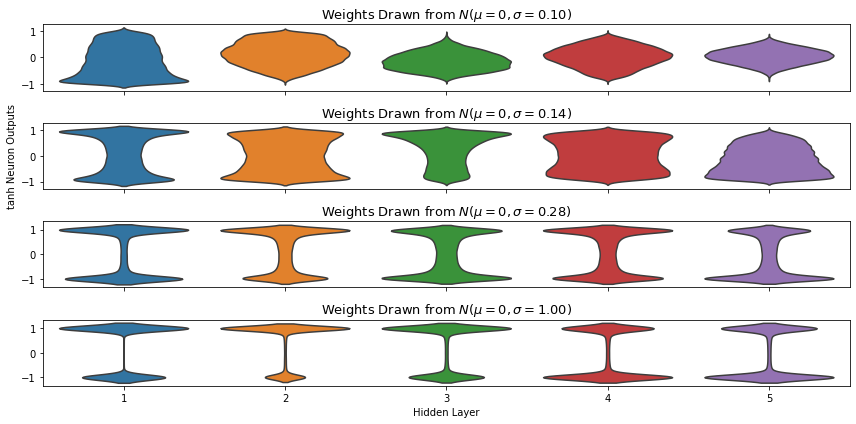

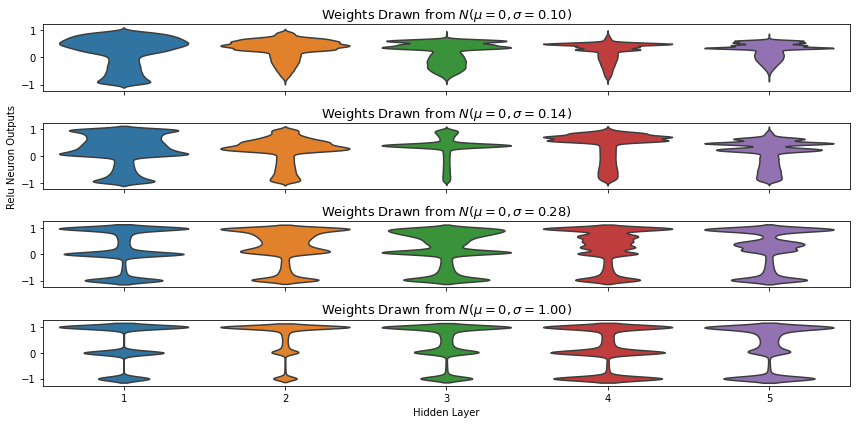

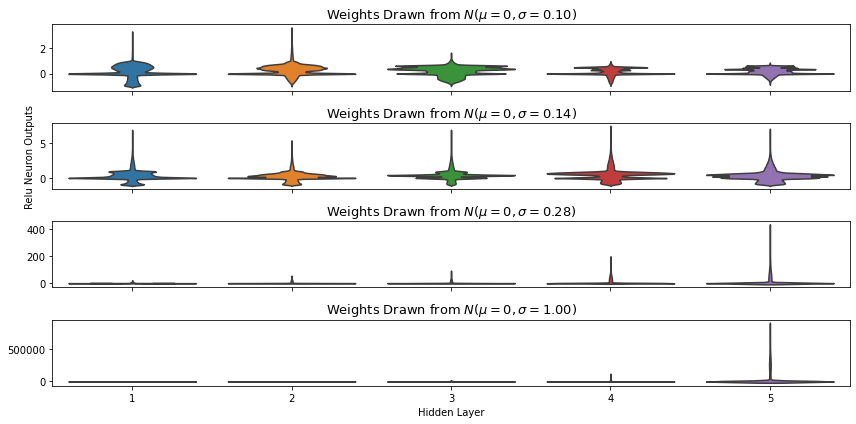

In [541]:
rows = []
sigmas = [0.10, 0.14, 0.28,1.00]

for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()
################################################################################

for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Relu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()
################################################################################

for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Relu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

#### As you may see in the three tables above, a standard normal distribution based initital weights will lead to very odd gradients for tanh and sigmoid activation functions, this is particularly true when  $\sigma\geq$ .28. On the other hand, when we use the same distribution for relu function, we can see clearly that gradients at layer 4 and below are vanishing for $\sigma \geq$ .28.

#### To properly account for this issue, Glorot and Bengio (2010) propose a Glorot/Xavier initalization to fix the varaince of input and output layer such that the $var(w_{i})=\frac{2}{n_{in}+n_{out}}$. See below an example of revisiting tanh activiation function using Glorot-based stnadard normal distribution.

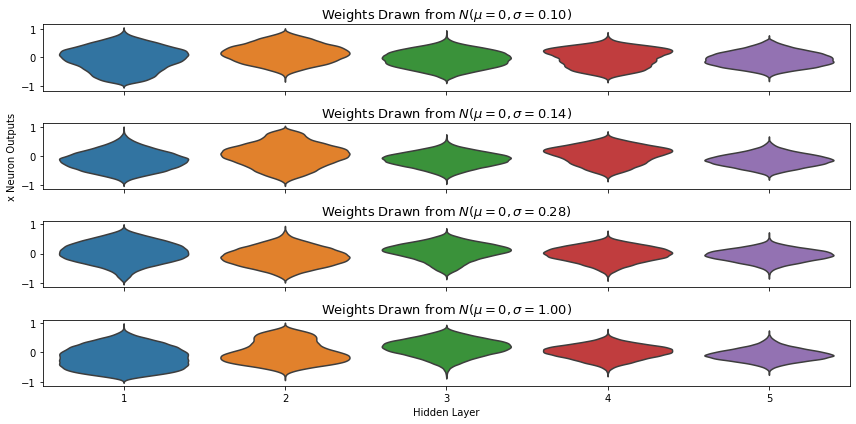

In [534]:
rows = []
sigmas = [0.10, 0.14, 0.28,1.00]

for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("x Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

#### As you may see above, all the gradients acorss different values of $\sigma$ look much stable, especially when  $\sigma=.14$ or $.28$. In what follows, we zoom in to these two scenarios for relu activiation function.

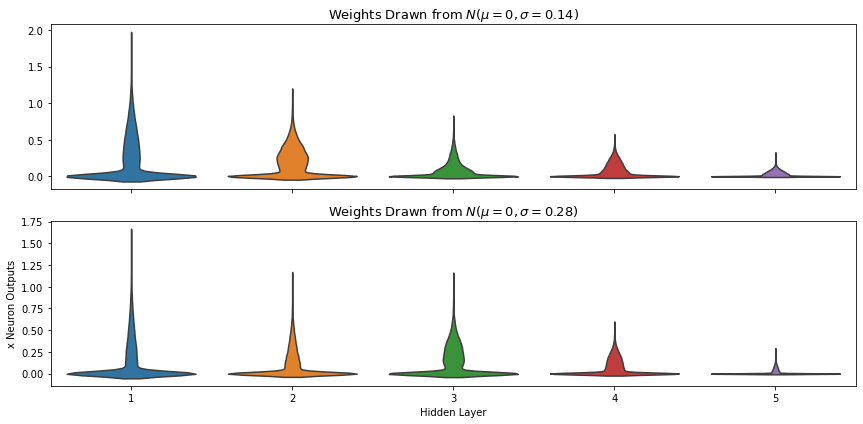

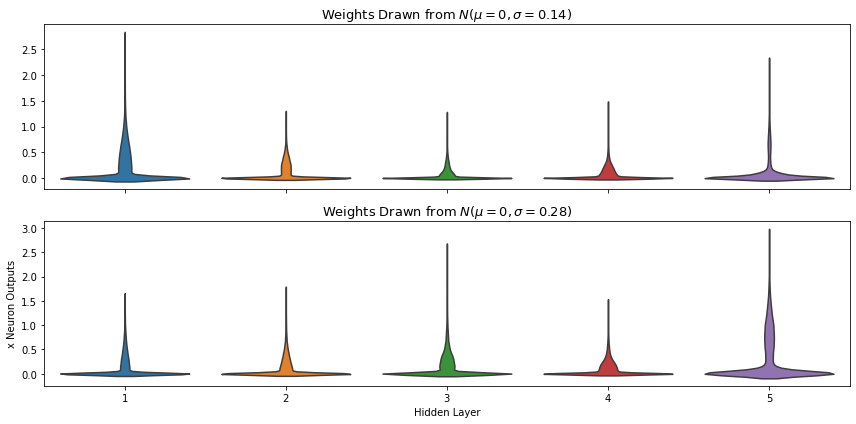

In [537]:
rows = []
sigmas = [0.14, 0.28]

for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("x Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

#############################################################################################################################

for stddev in sigmas:
    init = initializers.HeNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("x Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

#### It turns out that Glorot/Xavier initalization did not work well for relu activation function, where the size of gradients are not stable and getting larger as the layers decrease. This is mainly due to the definition of relu which set all negative value equal zero, which reduces half of the output variance. He et al.(2015) then proposed a solution for relu function which essentially set the variance of weight two times of that of Glorot-based initalization. In particular, they also find that using either the number of input or output edges willl do the job: $var(w_{i})=\frac{2}{n_{in}}$.

#### See the bottom graph using He initalization where gradients across all layers are stable.


#### 2.1

#### To sum up, I duscuss vanishing gradients phenomenon for tanh, sigmoid, and relu activation functions. 
#### The main takeaway is that we want our gradients to be stable across layers (to avoid vanishing/exploring phenomena), meaning mathmatically we need to set variances of input and output layer equal each other. 

#### Glorot inialization nicely takes care of this issue and proposes a simple form for normal and uniform-based distribution. 

#### He inialization further recognizes the nature of relu function and subsequently propose a better initalization scheme.


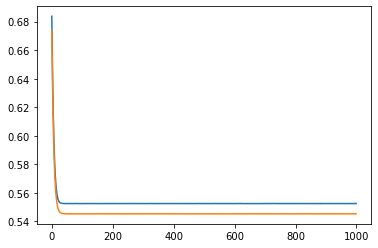

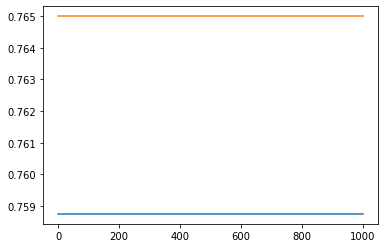

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
y = x*np.sin(5*x) 

X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1),y.reshape(-1,1), test_size=0.20, random_state=1)

y_train =to_categorical(y_train)
y_test =to_categorical(y_test)

model =keras.Sequential()
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(Dense(2,activation = 'softmax'))

loss_list = []
acc_list = []
val_loss_list = []
val_accuracy_list = []
rep = range(0,1000)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in rep:
    hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    loss_list.append(hist.history["loss"][0])
    acc_list.append(hist.history["accuracy"][0])
    val_loss_list.append(hist.history["val_loss"][0])
    val_accuracy_list.append(hist.history["val_accuracy"][0])
    
fig = plt.figure()

plt.plot(rep, loss_list)
plt.plot(rep,val_loss_list)

fig = plt.figure()
plt.plot(rep,acc_list)
plt.plot(rep,val_accuracy_list)

#### 2.2

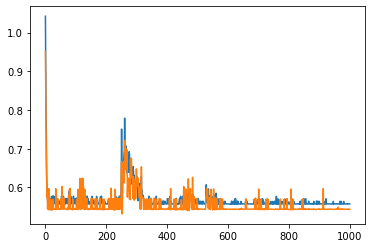

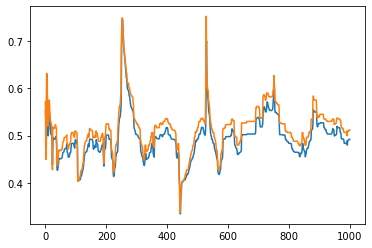

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
y = x*np.sin(5*x) 

X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1),y.reshape(-1,1), test_size=0.20, random_state=1)

y_train =to_categorical(y_train)
y_test =to_categorical(y_test)


model = keras.Sequential()

model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))
keras.layers.LeakyReLU(alpha=0.01)
model.add(Dense(2, kernel_initializer="he_normal"))

loss_list = []
acc_list = []
val_loss_list = []
val_accuracy_list = []
rep = range(0,1000)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in rep:
    hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    loss_list.append(hist.history["loss"][0])
    acc_list.append(hist.history["accuracy"][0])
    val_loss_list.append(hist.history["val_loss"][0])
    val_accuracy_list.append(hist.history["val_accuracy"][0])

fig = plt.figure()

plt.plot(rep, loss_list)
plt.plot(rep,val_loss_list)

fig = plt.figure()
plt.plot(rep,acc_list)
plt.plot(rep,val_accuracy_list)

#### 2.3

##### Althogh I did not show precisely the percentage of neural network collapse, the two graphs above one using Relu and the other using LeakyRelu show  LeakyRulu has done much better job for all key metrics meaning gradients are not vanishing(e.g., d(Relu(x))=0 if x<0 VS d(LeakyRelu(x))=$\alpha$ if x<0).

# Problem 3 - Batch Normalization, Dropout, MNIST

#### 3.1

#### Co-adaptation is a term that Srivastava et al. (2014) used to motivate the intuition behind using dropout as a mechamism to against overfitting in deep neural networks training. Specifically, in the context of deep learning, it refers to deep neural nets that are connected and highly ''familar'' with each other. By droping some of the complicated neural nets randomly, it decreases the co-habited probabilities so that the neural nets will proform better in the testing data, similar to the co-adaptation natural in sexual reproduction.

#### Internal covariance-shift refers to the situation where the distribution of deep neural network are changing from layer to layer, which tend to slow down the training process. Ioffe and Szegudy(2015) propose a method, batch normalization, to accelerate the training process by reducing internal covariance-shift. In general, the method requires to perform normlization in each batch of training subsets to allow faster learning rate.

#### 3.2

#### LeNet-5 Architecture below.

In [6]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="LeNet-5.PNG")

In [7]:
import numpy as np
import random
import gc
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense,Flatten,Conv2D,AveragePooling2D
from keras import backend as K
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization,LayerNormalization,Dropout
from keras.datasets import mnist

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")


tf.random.set_seed(1)
np.random.seed(1)
os.environ["PYTHONHASHSEED"] = str(1)                      
random.seed(1)



### Le-net5 with no normalization

In [8]:
def lenet5():
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = (28, 28, 1)),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            Dense(units = 84, activation = "tanh"),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    return model

model = lenet5()
model.summary()
model.compile(loss = "categorical_crossentropy", metrics = "accuracy", optimizer = "SGD")
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

print("LeNet5 Architecture\n")


(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))

x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


hist_0 = model.fit(x=x_train,y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

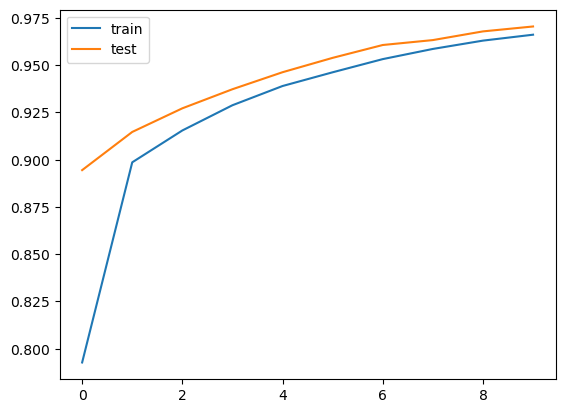

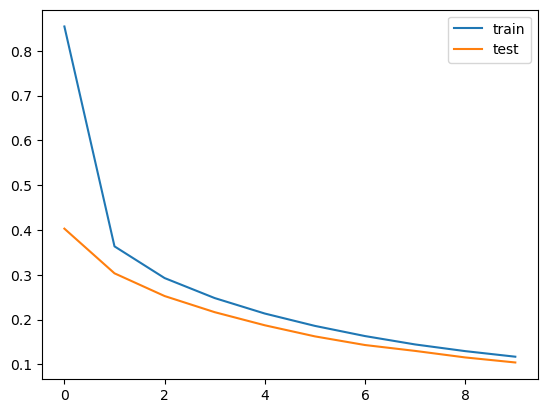

In [9]:
fig = plt.figure()
plt.plot(hist_0.history[ 'accuracy'], label='train')
plt.plot(hist_0.history[ 'val_accuracy'], label='test')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(hist_0.history['loss'], label='train')
plt.plot(hist_0.history['val_loss'], label='test')
plt.legend()
plt.show()

### Le-net5 with LayerNormalization (input layer) and BatchNormalization (hidden layers)

In [10]:
def lenet5():
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = (28, 28, 1)),
            LayerNormalization(),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            BatchNormalization(),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            BatchNormalization(),
            Dense(units = 84, activation = "tanh"),
            BatchNormalization(),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    return model

model = lenet5()
model.summary()
model.compile(loss = "categorical_crossentropy", metrics = "accuracy", optimizer = "SGD")
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

print("LeNet5 Architecture\n")


(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))

x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

keras.backend.clear_session()

hist_1 = model.fit(x=x_train,y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 layer_normalization (LayerN  (None, 24, 24, 6)        12        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 16)         64        
 ormalization)                                                   
                                                        

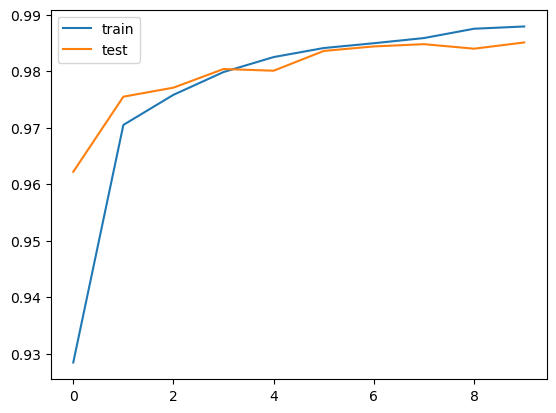

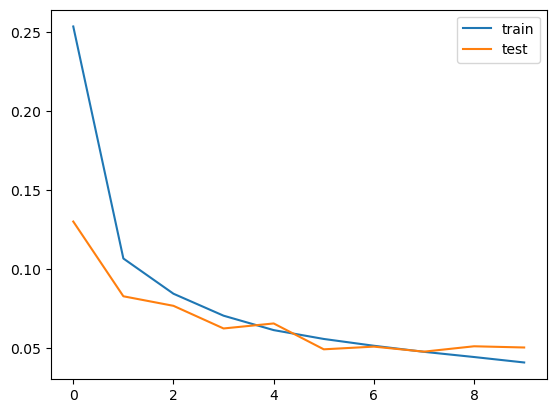

In [11]:
fig = plt.figure()
plt.plot(hist_1.history[ 'accuracy'], label='train')
plt.plot(hist_1.history[ 'val_accuracy'], label='test')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
lenet5_1 = model.get_layer('batch_normalization')
lenet5_1.weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(16,) dtype=float32, numpy=
 array([1.0491638 , 1.0946971 , 1.02648   , 1.1055462 , 1.063483  ,
        0.96129555, 1.0392615 , 0.98985475, 0.9771843 , 1.0112492 ,
        1.0232087 , 1.03155   , 0.99596506, 1.0151691 , 0.9778331 ,
        1.0134578 ], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(16,) dtype=float32, numpy=
 array([ 0.01705948, -0.00457107,  0.0362785 , -0.02978091, -0.04784808,
         0.02967496, -0.00566905,  0.00358235,  0.03915574, -0.02460461,
         0.06892986,  0.03131195,  0.04010868, -0.01540192,  0.03072008,
         0.0169348 ], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_mean:0' shape=(16,) dtype=float32, numpy=
 array([ 0.7593327 ,  0.07372059,  0.9005106 , -0.718137  , -0.04886445,
        -0.01591767, -0.71139514, -0.12254077,  0.38709894,  0.8217717 ,
        -0.34887108,  0.08065856, -0.30293828,  0.4288121 , -0.4489813 ,
        -0.1502836 ], dtype=float32)>,
 <t

#### 3.2 Firstly, comparing the two graphs above where one use Le-net5 with normazation and one without,  we can see that the one with standard normalization(input) and batchnormalization(hidden) has much better accuracy rate in both training and testing, and loss functions are smaller in genreal with a fast decrasing rate. 

#### Secondly, when it comes to the learnable paramters (scale and shift) in the batch process, it specificaly refer to beta and gamma  as the graph shown below. 

#### Credit of the graph goes to: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739.


In [5]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="batch.PNG")

### Le-net5 with BatchNormalization (input layer) and BatchNormalization (hidden layers)

In [13]:
def lenet5():
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = (28, 28, 1)),
            BatchNormalization(),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            BatchNormalization(),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            BatchNormalization(),
            Dense(units = 84, activation = "tanh"),
            BatchNormalization(),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    return model

model = lenet5()
model.summary()
model.compile(loss = "categorical_crossentropy", metrics = "accuracy", optimizer = "SGD")
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

print("LeNet5 Architecture\n")


(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))

x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

keras.backend.clear_session()

hist_2 = model.fit(x=x_train,y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 16)         64        
 hNormalization)                                                 
                                                        

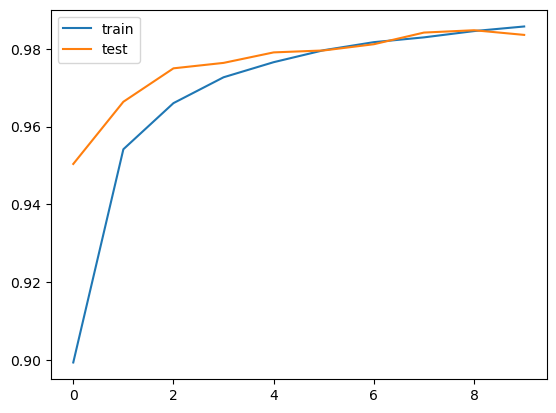

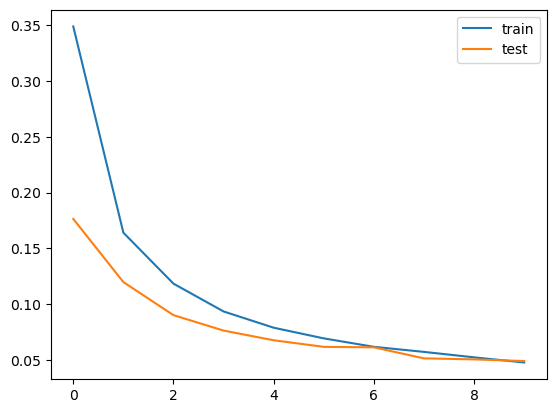

In [14]:
fig = plt.figure()
plt.plot(hist_2.history[ 'accuracy'], label='train')
plt.plot(hist_2.history[ 'val_accuracy'], label='test')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(hist_2.history['loss'], label='train')
plt.plot(hist_2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
lenet5_2 = model.get_layer('batch_normalization')
lenet5_2.weights
lenet5_2 = model.get_layer('batch_normalization_1')
lenet5_2.weights
lenet5_2 = model.get_layer('batch_normalization_2')
lenet5_2.weights
lenet5_2 = model.get_layer('batch_normalization_3')
lenet5_2.weights

[<tf.Variable 'batch_normalization_3/gamma:0' shape=(84,) dtype=float32, numpy=
 array([1.0981227, 1.0652944, 1.0820545, 1.0532032, 1.0584794, 1.1011133,
        1.018255 , 1.038853 , 1.0829537, 1.0901052, 1.0570672, 1.0825405,
        1.1023039, 1.0445476, 1.0440514, 1.0259345, 1.0735805, 1.0615755,
        1.0293999, 1.0824815, 1.0752047, 1.0943738, 1.0793762, 1.1148537,
        1.0384781, 1.0375277, 1.0384891, 1.0237898, 1.0439254, 1.0191499,
        1.0480534, 1.0384159, 1.0419827, 1.0298542, 1.0225049, 1.0622873,
        1.0079575, 1.1111728, 1.0629538, 1.0659451, 1.0788624, 1.0641792,
        1.0150821, 1.0465072, 1.0567827, 1.0366145, 1.0350362, 1.0102944,
        1.0401511, 1.1006815, 1.0584102, 1.0754942, 1.1200128, 1.0776569,
        1.0935671, 1.1159856, 1.1252662, 1.0577819, 1.030938 , 1.0484583,
        1.004215 , 1.2127982, 1.0104257, 1.0535251, 1.0780643, 1.0628188,
        1.0558742, 1.1001636, 1.0673838, 1.0495186, 1.0388838, 1.0337132,
        1.0373757, 1.0607677, 1.

#### 3.3 Using batchnormlization in the input layer, generally speaking, performs slighly less efficient as compared to the one using normlization in the input layer. 

#### Specifically, comparing the graph above to the one I discussed in 3.2, we may see that although the accuracy at epoch 10 is the same, the accurate rate  at epoch 0 is lower and has a higher loss rate as compared to the one using normlization layer instead.

###  Le-net5 with Dropout only

In [7]:
def lenet5():
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = (28, 28, 1)),
            Dropout(.2),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            Dropout(.5),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            Dropout(.5),
            Dense(units = 84, activation = "tanh"),
            Dropout(.5),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    return model

model = lenet5()
model.summary()
model.compile(loss = "categorical_crossentropy", metrics = "accuracy", optimizer = "SGD")
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

print("LeNet5 Architecture\n")


(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))

x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


hist_4 = model.fit(x=x_train,y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 dropout (Dropout)           (None, 24, 24, 6)         0         
                                                                 
 average_pooling2d_4 (Averag  (None, 12, 12, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)          0         
                                                                 
 average_pooling2d_5 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                          

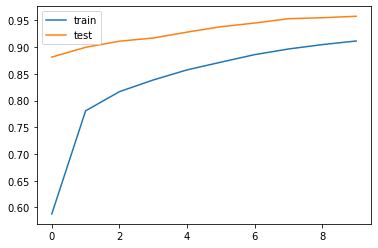

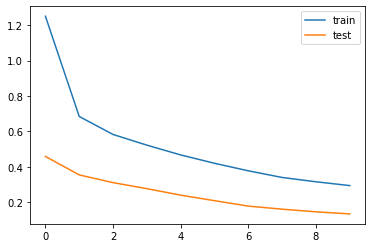

In [11]:
fig = plt.figure()
plt.plot(hist_4.history[ 'accuracy'], label='train')
plt.plot(hist_4.history[ 'val_accuracy'], label='test')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(hist_4.history['loss'], label='train')
plt.plot(hist_4.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 3.4 Using Dropout instead of BatchNormlization reduces the test accuracy from 0.98 to 0.945 roughly(for the epoch 10, and it also has a much lower initial accuracy rate for both train/test accuracy. Moreover, the loss function is two times larter than the one using normalization layer meaning there are many bias using dropout.

### Le-net5 with both BatchNormalization and Dropout

In [20]:
def lenet5():
    
    model = Sequential(
        [
            Conv2D(filters = 6, kernel_size = (5, 5), strides = (1, 1), activation = "tanh", input_shape = (28, 28, 1)),
            BatchNormalization(),
            Dropout(.2),
            AveragePooling2D(pool_size = (2, 2)),
            Conv2D(filters = 16, kernel_size = (5, 5), strides = (1, 1), activation = "tanh"),
            BatchNormalization(),
            Dropout(.5),
            AveragePooling2D(pool_size = (2, 2), strides = 2),
            
            Flatten(),
            Dense(units = 120, activation = "tanh"),
            BatchNormalization(),
            Dropout(.5),
            Dense(units = 84, activation = "tanh"),
            BatchNormalization(),
            Dropout(.5),
            Dense(units = 10, activation = "softmax")
        ]
    )
    
    return model

model = lenet5()
model.summary()
model.compile(loss = "categorical_crossentropy", metrics = "accuracy", optimizer = "SGD")
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

print("LeNet5 Architecture\n")


(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))

x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

keras.backend.clear_session()

hist_5 = model.fit(x=x_train,y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 6)        24        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 6)         0         
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 16)         6

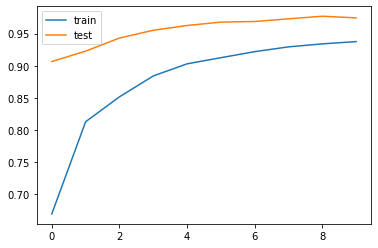

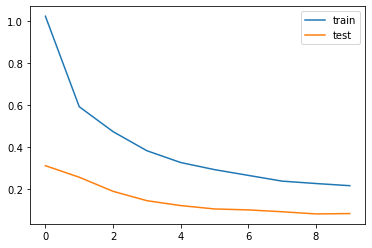

In [12]:
fig = plt.figure()
plt.plot(hist_5.history[ 'accuracy'], label='train')
plt.plot(hist_5.history[ 'val_accuracy'], label='test')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(hist_5.history['loss'], label='train')
plt.plot(hist_5.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 3.5 In this instance, we see that the loss function is relative the same as those using BatchNormalization only. However, the test accuracy is still lower than those using BatchNormalization only.

#### In general, the curvature of accuracy looks a lot like the one using Dropout only, which tells me that using BatchNormalization only is better overall( at least for this dataset and this architecture).

# Problem 4 - Universal Approximators: Depth Vs. Width

In [17]:
import numpy as np
import time
import random
import gc
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from itertools import permutations,combinations
from tensorflow.keras import layers
from keras.layers import Dense,Flatten,Conv2D,AveragePooling2D
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization,LayerNormalization,Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

np.random.seed(1)
               

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")


data = np.random.uniform(-512, 512, size=(1000000,2))
x_1,x_2= data[:,0],data[:,1]
x = data
y = (-(x_2 + 47) * np.sin(np.sqrt(np.absolute(x_1/2 + (x_2  + 47)))) - x_1 * np.sin(np.sqrt(np.absolute(x_1 - (x_2  + 47))))) + np.random.normal(0,0.3)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.20, random_state=1)





In [18]:
units_3  = combinations([16, 32, 64, 128, 256], 3) 

para_3 = []
record_3 = []
rmse_3 = {}

for i in list(units_3):
    
    l_3 = Sequential([ Dense(i[0], activation = 'relu', input_dim = 2),
                       BatchNormalization(),
                       Dense(i[1], activation = 'relu'),
                       BatchNormalization(),
                       Dense(i[2], activation = 'relu'),
                       BatchNormalization(),
                       Dense(units = 1)])
    l_3.compile(optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.00001,momentum=0.1, nesterov=True), loss = 'mse',metrics=[RootMeanSquaredError()])
    start = time.time()
    hist=l_3.fit(X_train, Y_train, batch_size = 1000, epochs = 2000, validation_data=(X_test,Y_test),shuffle=True,verbose=0)
    end= time.time()
    
    
    temp_unit = i[0]+i[1]+i[2]
    if temp_unit not in rmse_3:
        para_3.append(l_3.count_params())
        record_3.append((end-start)*100)
        rmse_3[temp_unit]=hist.history['val_root_mean_squared_error'][-1]
    else:
        temp =min(rmse_3[temp_unit],hist.history['val_root_mean_squared_error'][-1])
        up_dict = {temp_unit:temp}
        rmse_3.update(up_dict)   

In [19]:
units_2  = combinations([16, 32, 64, 128, 256], 2) 


para_2 = []
record_2 = []
rmse_2 = {}
for i in list(units_2):
    l_2 = Sequential([ Dense(i[0], activation = 'relu', input_dim = 2),
                       BatchNormalization(),
                       Dense(i[1], activation = 'relu'),
                       BatchNormalization(),
                       Dense(units = 1)])
    l_2.compile(optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.00001,momentum=0.1,nesterov=True), loss = 'mse',metrics=[RootMeanSquaredError()])
    start = time.time()
    hist=l_2.fit(X_train, Y_train, batch_size = 1000, epochs = 2000, validation_data=(X_test,Y_test),shuffle=True,verbose=0)
    end= time.time()
    
    temp_unit = i[0]+i[1]

    if temp_unit not in rmse_2:
        para_2.append(l_2.count_params())
        record_2.append((end-start)*100)
        rmse_2[temp_unit]=hist.history['val_root_mean_squared_error'][-1]
    else:
        temp =(rmse_2[temp_unit]+hist.history['val_root_mean_squared_error'][-1])/2
        up_dict = {temp_unit:temp}
        rmse_2.update(up_dict)  

In [20]:
units  = [16, 32, 64, 128, 256, 512]
rmse = []
para = []
record = []

for i in units:
    l_1 = Sequential([ Dense(i, activation = 'relu', input_dim = 2),Dense(units = 1)])
    l_1.compile(optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.00001,momentum=0.1, nesterov=True), loss = 'mse',metrics=[RootMeanSquaredError()])
    
    start = time.time()
    hist=l_1.fit(X_train, Y_train, batch_size = 1000, epochs = 2000, validation_data=(X_test,Y_test),shuffle=True,verbose=0)
    end = time.time()
    
    para.append(l_1.count_params())
    rmse.append(hist.history['val_root_mean_squared_error'][-1])
    record.append((end-start)*100)

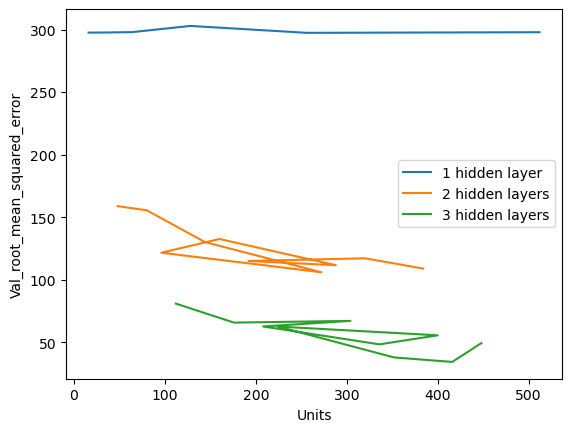

In [30]:
rmse_2_ = list(rmse_2.values())
rmse_3_ = list(rmse_3.values())
key_2 = list(rmse_2.keys())
key_3 = list(rmse_3.keys())

fig = plt.figure()
plt.plot(units,rmse,label='1 hidden layer')
plt.plot(key_2,rmse_2_,label='2 hidden layers')
plt.plot(key_3,rmse_3_,label='3 hidden layers')
plt.ylabel('Val_root_mean_squared_error')
plt.xlabel('Units')
plt.legend()
plt.show()

In [29]:
key_3

[112, 176, 304, 208, 336, 400, 224, 352, 416, 448]

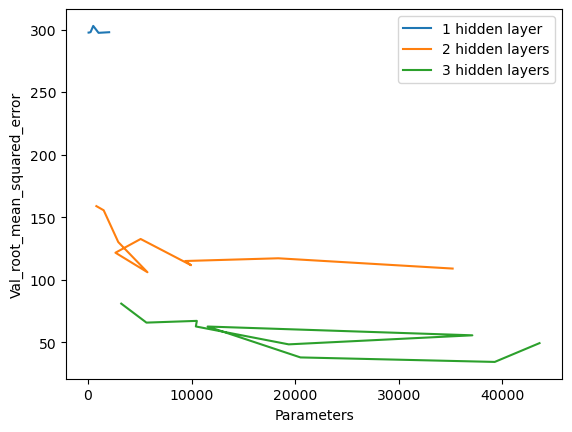

In [31]:
fig = plt.figure()
plt.plot(para, rmse,label='1 hidden layer')
plt.plot(para_2, rmse_2_,label='2 hidden layers')
plt.plot(para_3, rmse_3_,label='3 hidden layers')
plt.ylabel('Val_root_mean_squared_error')
plt.xlabel('Parameters')
plt.legend()
plt.show()

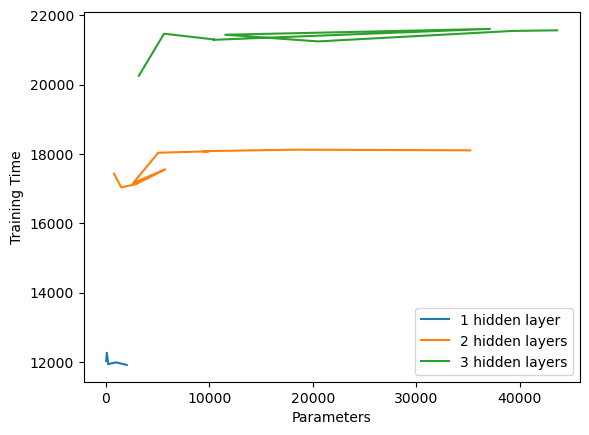

In [32]:
fig = plt.figure()
plt.plot(para, record,label='1 hidden layer')
plt.plot(para_2, record_2,label='2 hidden layers')
plt.plot(para_3, record_3,label='3 hidden layers')
plt.ylabel('Training Time')
plt.xlabel('Parameters')
plt.legend()
plt.show()